# Fundamentals of Statistical Process Monitoring 

*Purpose*: In future exercises we're going to learn how to model variable quantities as random, but before we do that, we need tools to help decide if a given quantity *should* be modeled as random. The tools of *statistical process monitoring* (sometimes called *statistical process control*) will help us find non-random patterns in data, which can be helpful for deciding whether or not a quantity can be reasonably modeled as random.


## Setup


In [1]:
import grama as gr
import numpy as np
DF = gr.Intention()
%matplotlib inline

# Theory


It's difficult to tell by-inspection if data are random. For example, let's look at a completely random dataset:


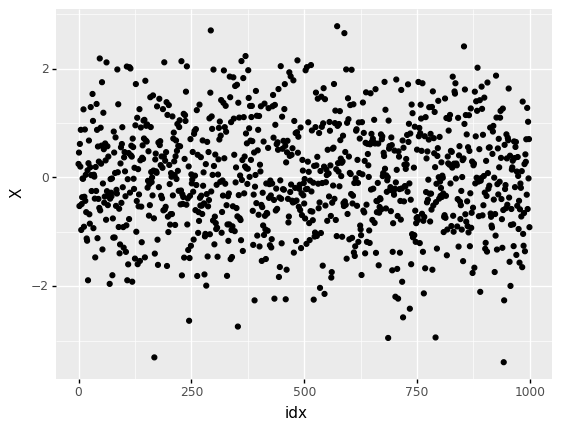

<ggplot: (8767803297711)>

In [2]:
## NOTE: No need to edit; run and inspect
np.random.seed(102)

mg_normal = gr.marg_mom("norm", mean=0, sd=1)
df_random = (
    gr.df_make(X=mg_normal.r(1000))
    >> gr.tf_mutate(idx=DF.index)
)

(
    df_random
    >> gr.ggplot(gr.aes("idx", "X"))
    + gr.geom_point()
)

Some observations:

- Without some sense of *reasonable limits*, we can't distinguish outliers from the normal highs and lows of randomness.
- Without some knowledge of the underlying random process, we cannot define reasonable limits.


Rather than do concentrated staring at random patterns, we can make some *intelligent choices* about grouping observations, and use *batch averages* to set meaningful *control limits*. These ideas combine in a *control chart*; the following plot is our first example of a control chart.

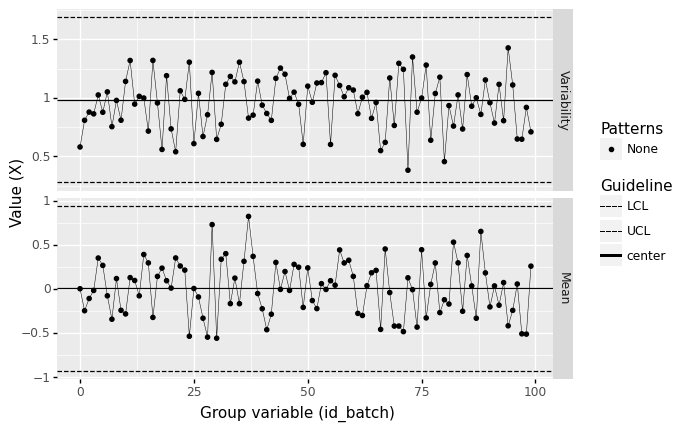

<ggplot: (8767803564788)>

In [3]:
%%capture --no-display
## NOTE: No need to edit

(
    df_random 
    ## Group observations into consecutive batches of 10
    >> gr.tf_mutate(id_batch=DF.index // 10)
    ## Construct an Xbar and S (xbs) chart
    >> gr.pt_xbs(group="id_batch", var="X")
)

From this chart, we see no outliers outside the lower control limit (LCL) or upper control limit (UCL). We also don't see any special patterns in the data. Therefore, based on this control chart, we can declare that the process is likely under *statistical control*---that it can be modeled as random.


## X-bar and S Chart

The helper function `gr.pt_xbs()` constructs a particular kind of control chart: an X-bar and S chart. This shows both the *batch* sample standard deviation (S) and *batch* sample mean (X-bar), along with *control limits* for these quantities. This statistical tool helps us find suspicious patterns in a dataset.

In order to understand X-bar and S charts, we need understand why we take *batch averages*, and how to construct meaningful *control limits* for X-bar and S.


## Batch Averages

We saw before that the *sample mean* follows the central limit theorem, which tells us about the distribution of the sample mean if we were to observe multiple, independent datasets. Thus taking the average of multiple observations *from the same process* gives us a way to make the underlying distribution more predictable.

However, taking the average of *all* observations $n_{\text{total}}$ prevents us from determining *where* an outlier occurred: If the mean of all the data is high, was it the first observation that was large? The last one? Something in the middle?

Therefore, we'll split the data into batches of a much smaller size $n_{\text{batch}} << n_{\text{total}}$. Taking *batch averages* gives us better resolution (allowing us to determine which batch is worth further investigation), while still giving the advantages of the central limit theorem.


## Control limits: Confidence Intervals

Remember (from [e-stat05-CI](https://zdelrosario.github.io/evc-course/exercises_solution/d21-e-stat05-CI-solution.html)) that the central limit theorem-based confidence interval for the sample mean is given by

$$[\overline{X}_n - z_C \sigma/\sqrt{n}, \overline{X}_n + z_C \sigma/\sqrt{n}]$$

where $z_C$ is the relevant quantile of a standard normal distribution, and $n$ is the number of observations in our sample. For control charts, it is standard to choose a very strict confidence level of $C = 1 - 1/1000$.

To understand how we will *use* the idea of confidence intervals to look for non-random patterns, let's remind ourselves of the *golden rule for interpreting confidence intervals*:

```{admonition} The "Golden Rule" for interpreting Confidence Intervals
When interpreting a confidence interval, we should assume the true value could be anywhere inside the interval.
```

With a control chart, we want to be able to tell *when* a pattern in the data looked non-random. To that end, we'll study the sample means of small *batches* of the data, and compare all of those batches to a single confidence interval. Since the confidence interval is a reasonable range for the true value, we will flag batch means that fall outside the confidence interval as potentially non-random, and worth of further investigation.


When constructing a control chart, we use the *entire* dataset to estimate the mean $\overline{X}_{n_{\text{total}}}$ and standard deviation $\sigma$, but construct the confidence interval based on the batch size $n_{\text{batch}}$. That looks like:

$$[\overline{X}_{n_{\text{total}}} - z_C \sigma/\sqrt{n_{\text{batch}}}, \overline{X}_{n_{\text{total}}} + z_C \sigma/\sqrt{n_{\text{batch}}}]$$

The helper function `gr.pt_xbs()` automates the approximation of these control limits. In the rest of this exercise, we'll focus on grouping the observations into reasonable batches.

```{admonition} See the references for the gory statistical details
When it comes to approximating the standard deviation $\sigma$ for a control chart, there is actually a bit more work we have to do to *de-bias* the standard deviation. The control limits for the standard deviation also follow a different formula than the sample mean. For more details, see the references listed at the bottom of this exercise.
```

## Grouping observations

Ideally, the selection of batches should be made during the *planning* of data collection. If we are studying archival data, we can sometimes make some reasonable assumptions about data collection in order to define batches.


### Natural batches

In cases when we can *plan* data collection, there are likely candidates for "natural" batches of data. For instance, if we have multiple machines that are used (separately) to make the same part, we could group observations based on which machine led to their manufacture. 

The next code chunk simulates data where multiple machines are used to manufacture the same part---one of the machines is malfunctioning. You'll use a control chart to help determine which machine is causing problems.


In [4]:
## NOTE: No need to edit
np.random.seed(101)

df_base = gr.df_make(
    sd=[0.01, 0.04, 0.01, 0.01, 0.01, 0.01],
    ma=[ "A",  "B",  "C",  "D",  "E",  "F"],
)
mg = gr.marg_mom("norm", mean=0, sd=1)

df_machines = gr.df_grid()
for i in range(df_base.shape[0]):
    df_machines = (
        df_machines
        >> gr.tf_bind_rows(
            gr.df_make(
                X=mg.r(15) * df_base.sd[i],
                id_machine=df_base.ma[i],
            )
        )
    )
# Randomly sort
df_machines = (
    df_machines
    >> gr.tf_sample(frac=1)
)


### __q1__ Batch by machine

Construct a control chart using the machine identifier as the `group` variable. Look for patterns in the measured quantity `X`. Answer the questions under *observations* below.

*Hint*: Remember to read the documentation for an unfamiliar function to learn about its arguments.


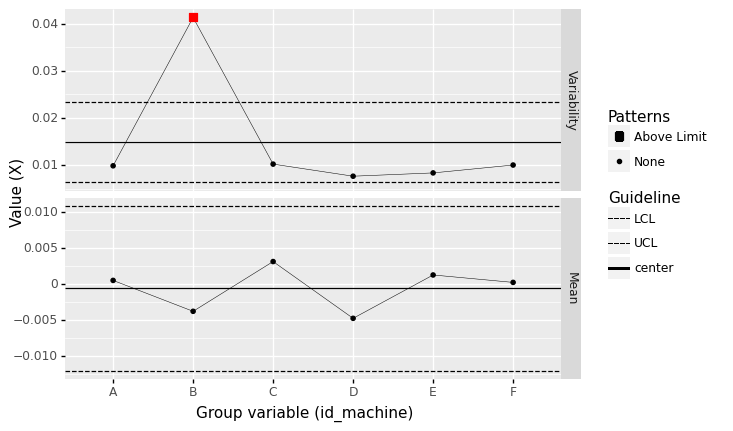

<ggplot: (8767781667810)>

In [5]:
%%capture --no-display
## TODO: Create a control chart grouped by machine
(
    df_machines
# solution-begin    
    >> gr.pt_xbs(group="id_machine", var="X")
# solution-end    
)

*Observations*

- Based on the batch size you chose, did you find any out-of-control patterns?
  - Yes, I see out-of-control variability for Machine B.
- If you answered "yes" to the previous question, does your group variable give you a meaningful way to determine what may have cause the out-of-control pattern?
  - Yes! Batching by machine gives us an obvious clue about where the out-of-control behavior occurred.
<!-- solution-end -->

### Batches in time

Natural batches---such as per-machine as above---are a fine way to choose the grouping for a control chart. However, there are other ways to batch the data.

Another way to batch the data is by *consecutive periods of time*; this can be helpful for monitoring a single data-generating process to see if something happened at a particular point in time.

When choosing consecutive observations, we should choose *reasonable* batch sizes $n_{\text{batch}}$. The following rule of thumb is helpful for picking a reasonable $n_{\text{batch}}$.

> A rule of thumb is to use three time periods with 20 to 25 samples of size $n_{\text{batch}} = 50$ to $n_{\text{batch}} = 100$ units each.

The following code simulates data from a process that varies over time. The data collection plans for 45 samples, each containing $n_{\text{batch}} = 50$ observations. This results in `45 * 50 = 2250` observations total.


In [6]:
## NOTE: No need to edit
np.random.seed(101)

df_base = gr.df_make(
    mu=[0]*30 + list(gr.linspace(0, 0.8, 15)),
)
mg = gr.marg_mom("norm", mean=0, sd=1)

df_time = gr.df_grid()
for i in range(df_base.shape[0]):
    df_time = (
        df_time
        >> gr.tf_bind_rows(
            gr.df_make(X=mg.r(50) + df_base.mu[i])
        )
    )
# Randomly sort
df_time = (
    df_time
    >> gr.tf_mutate(t=DF.index/gr.n(DF.index))
    >> gr.tf_sample(frac=1)
)


### __q2__ Create consecutive groups

Use a mutate to create a column `id_seq` to group sequential observations.

*Hint 1*: Remember that floor division `x // y` is one way to create sequential values.

*Hint 2*: Remember that `DF.index` allows you to access the index of each row in a DataFrame.


In [7]:
## TASK: Create a column `id_seq` to group sequential observations
df_seq = (
    df_time

    >> gr.tf_mutate(id_seq=DF.index // 50)
# solution-end    
)

## NOTE: Use this to check your work
assert \
    "id_seq" in df_seq.columns, \
    "df_seq does not have a column `id_seq`"

print(
    "You grouped the observations into {0:} samples of size n_batch = {1:}".format(
        len(set(df_seq.id_seq)),
        len(df_seq[df_seq.id_seq == df_seq.id_seq.values[0]]),
    )
)

print(df_seq >> gr.tf_head(20))

You grouped the observations into 45 samples of size n_batch = 50
           X         t  id_seq
0   2.605316  0.801333       0
1  -0.234766  0.080444       0
2  -0.950839  0.888889       0
3  -1.340159  0.527556       0
4   0.563586  0.999556       0
5   0.372806  0.253778       0
6   1.378403  0.080000       0
7   1.031736  0.288000       0
8   0.639372  0.916889       0
9   1.186054  0.336000       0
10  0.083397  0.545333       0
11 -0.683701  0.935556       0
12 -0.388190  0.505333       0
13  0.139908  0.761333       0
14  0.978535  0.296444       0
15 -0.187721  0.272889       0
16 -0.063713  0.812444       0
17  0.759567  0.749778       0
18  0.087531  0.587111       0
19  0.150913  0.484889       0


### __q3__ Batch by slices of time

Sort the data by time `t`, then batch the observations into consecutive groups and construct a control chart. 

Make sure to *match* the batch size $n_{\text{batch}}$ used in data collection.

Answer the questions under *observations* below.


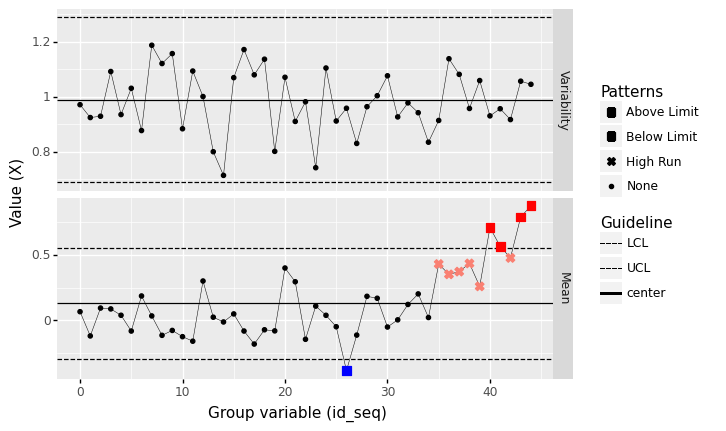

<ggplot: (8767816020839)>

In [8]:
%%capture --no-display
## TODO: Arrange the dataset by time `t` and batch appropriately
df_timebatch = (
    df_time
# solution-begin    
    >> gr.tf_arrange(DF.t)
    >> gr.tf_mutate(id_seq=DF.index // 50)
# solution-end    
)

## NOTE: No need to edit; use this to check your work
assert \
    "id_seq" in df_timebatch.columns, \
    "df_timebatch does not have a column `id_seq`"

assert \
    len(df_timebatch[df_timebatch.id_seq == df_timebatch.id_seq.values[0]]) == 50, \
    "You did not choose a batch size n_batch that matches the data collection"
    
# Visualize
(
    df_timebatch
    >> gr.pt_xbs(group="id_seq", var="X")
)

*Observations*

*Hint*: You will *not* see any patterns if you do not properly arrange the data.

- Based on the batch size you chose, did you find any out-of-control patterns?
  - Arranged by time and with a batch size of `n=50`, I see one low mean and a long string of high-mean batches.
- If you answered "yes" to the previous question, does your group variable give you a meaningful way to determine what may have cause the out-of-control pattern?
  - Yes; since the batches are arranged in time, we can see that the process was trending upward in time towards the end of the period.
<!-- solution-end -->

## Naive consecutive rows

What happens if we do not correctly arrange the rows? Then we lose all information about the time history of the data. The following plot shows what happens if we construct a control chart without respecting the time ordering of the data:

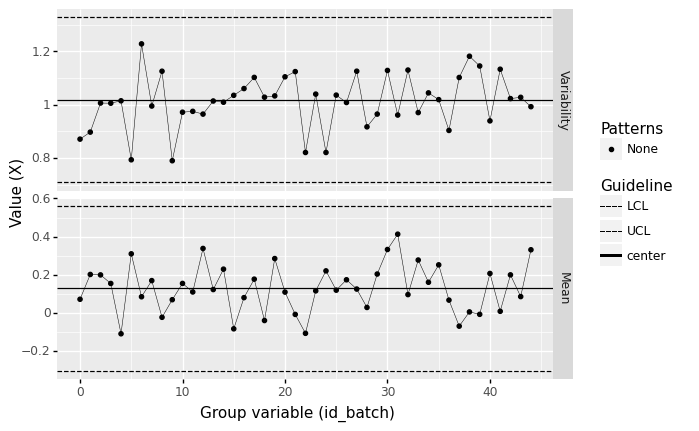

<ggplot: (8767765421743)>

In [9]:
%%capture --no-display
## NOTE: No need to edit; run and inspect
(
    df_time
    >> gr.tf_mutate(id_batch=DF.index // 50)
    >> gr.pt_xbs(group="id_batch", var="X")
)

Note that there are no patterns in this view of the data!


# Patterns to seek

Kenett and Zacks (2014) highlight several patterns that can signal an out-of-control manufacturing process:

> 1. A single point outside the control limits.
> 2. A run of nine or more points in a row above (or below) the centerline.
> 3. Six consecutive points increasing (trend up) or decreasing (trend down).

The following cells simulate data to illustrate each of these patterns.


## Outside control limits

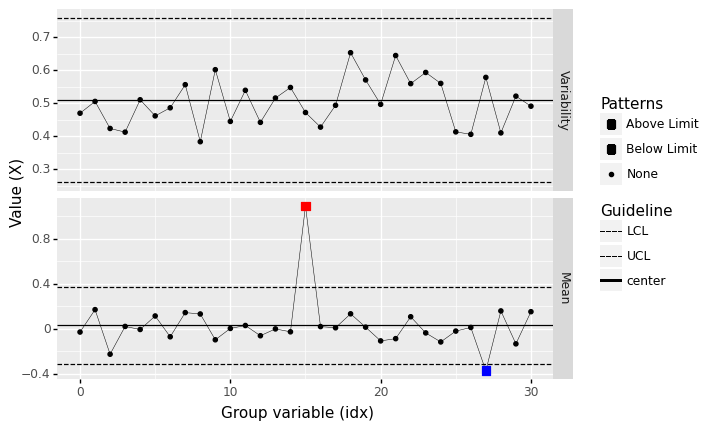

<ggplot: (8767781669777)>

In [10]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0]*15 + [1]*1 + [0]*15 
mg_standard = gr.marg_mom("norm", mean=0, sd=0.5)

df_outlier = gr.df_grid()
for i, m in enumerate(mu):
    df_outlier = (
        df_outlier
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_outlier
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

## Variability out-of-control


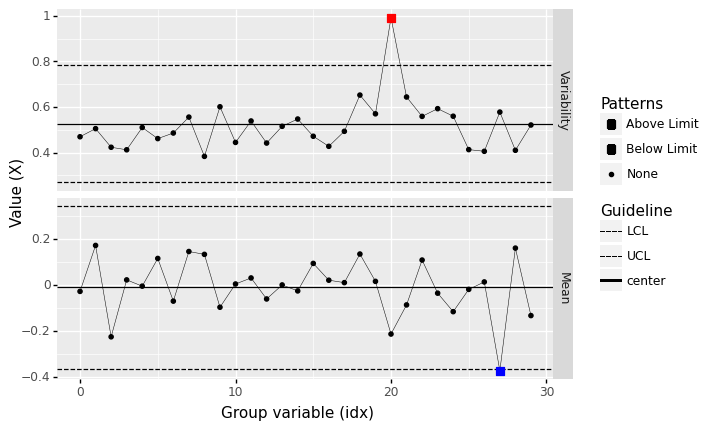

<ggplot: (8767816294488)>

In [11]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0]*30
mg_standard = gr.marg_mom("norm", mean=0, sd=0.5)

df_outlier = gr.df_grid()
for i, m in enumerate(mu):
    df_outlier = (
        df_outlier
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) * (1 + (i == 20)) + m
        ))
    )
    
(
    df_outlier
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

## Runs above center

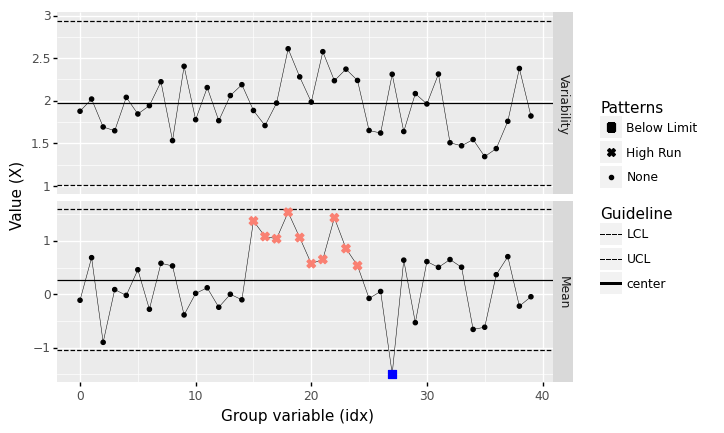

<ggplot: (8767804037063)>

In [12]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0]*15 + [1]*10 + [0]*15 
mg_standard = gr.marg_mom("norm", mean=0, sd=2.0)

df_above = gr.df_grid()
for i, m in enumerate(mu):
    df_above = (
        df_above
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_above
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

Note that none of the observations exceed the upper control limit (UCL), but a "run" of many (9 or more) observations above the centerline is highly unlikely to be due to chance alone. 


## Runs below center


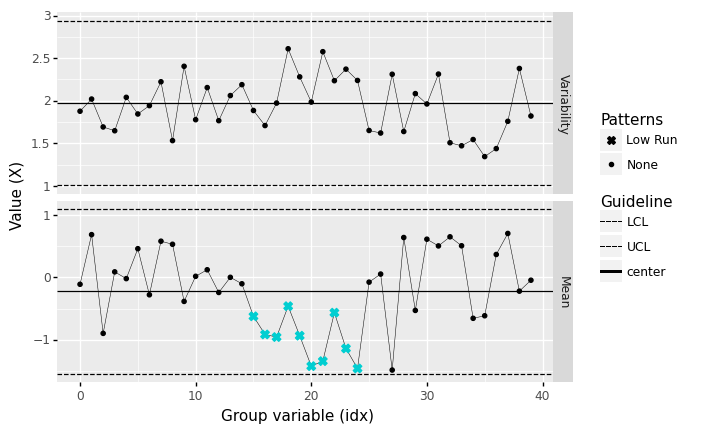

<ggplot: (8767816335833)>

In [13]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0]*15 + [-1]*10 + [0]*15 
mg_standard = gr.marg_mom("norm", mean=0, sd=2.0)

df_below = gr.df_grid()
for i, m in enumerate(mu):
    df_below = (
        df_below
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_below
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

## Runs increasing


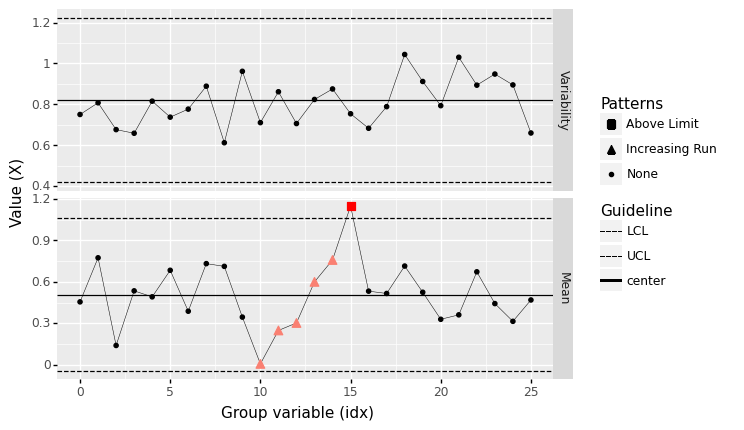

<ggplot: (8767804402354)>

In [14]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0.5]*10 + list(gr.linspace(0, 1, 6)) + [0.5]*10
mg_standard = gr.marg_mom("norm", mean=0, sd=0.8)

df_increase = gr.df_grid()
for i, m in enumerate(mu):
    df_increase = (
        df_increase
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_increase
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

## Runs decreasing


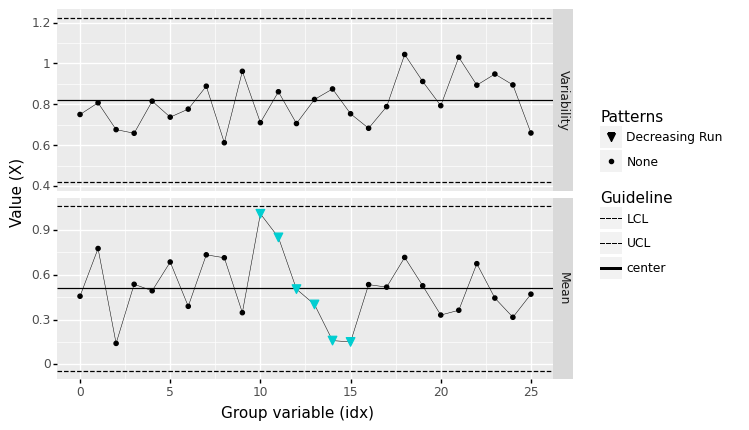

<ggplot: (8767765530483)>

In [15]:
%%capture --no-display
## NOTE: No need to edit
np.random.seed(101)

n = 20
mu = [0.5]*10 + list(1 - gr.linspace(0, 1, 6)) + [0.5]*10
mg_standard = gr.marg_mom("norm", mean=0, sd=0.8)

df_decrease = gr.df_grid()
for i, m in enumerate(mu):
    df_decrease = (
        df_decrease
        >> gr.tf_bind_rows(gr.df_make(
            X=mg_standard.r(n) + m
        ))
    )
    
(
    df_decrease
    >> gr.tf_mutate(idx=DF.index // n)
    >> gr.pt_xbs(group="idx", var="X")
)

# Warnings

While we should be on the lookout for patterns in a control chart, we should balance this out with a healthy dose of skepticism. The following two examples demonstrate cases where we would see patterns in a control chart that have no real meaning.


## Beware spurious patterns!

Note that *false patterns* can still occur based on random events. These false patterns become more likely with smaller batch sizes. For instance, let's take a look at the completely random dataset from above, batched into tiny subgroups:


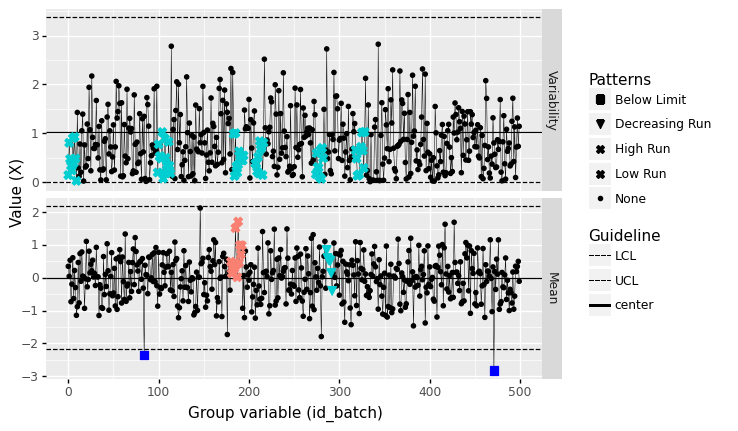

<ggplot: (8767816337005)>

In [16]:
%%capture --no-display
## NOTE: No need to edit

(
    df_random 
    >> gr.tf_mutate(id_batch=DF.index // 2)
    >> gr.pt_xbs(group="id_batch", var="X")
)

Note that a variety of "patterns" are detected, but these cannot possibly be due to any assignable causes: The data are completely random by construction. Using a larger batch size helps to protect us against being mislead by random patterns, but keep in mind that false detections are always possible!


## Beware meaningless order

Patterns based on order (such as high/low or increasing/decreasing runs) are meaningless when order of the group variable has no meaning. For instance, we can reorder the machine identifiers in `df_machines` to artificially create an increasing run:


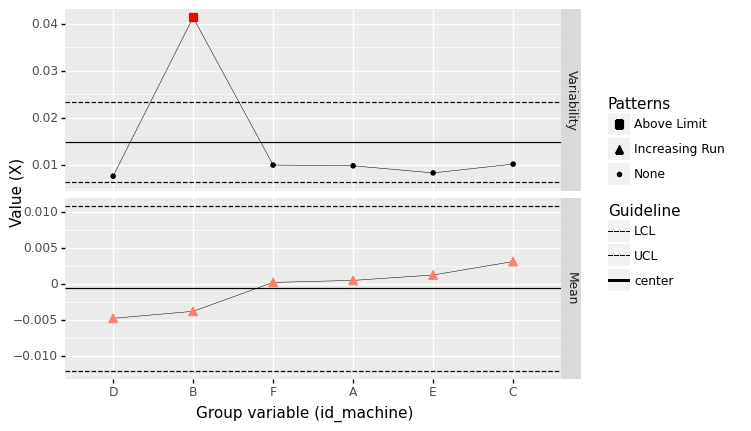

<ggplot: (8767781843709)>

In [17]:
%%capture --no-display
## NOTE: No need to edit
(
    df_machines
    >> gr.tf_mutate(id_machine=gr.fct_reorder(DF.id_machine, DF.X, fun=gr.mean))
    >> gr.pt_xbs(group="id_machine", var="X")
)

Here the batch means are increasing, but that is only because we ordered the machines by their batch mean!


# Example: Cast Aluminum Dataset

Let's take a closer look at the cast aluminum dataset using our new lense of control charts.


In [18]:
from grama.data import df_shewhart
df_shewhart.head()

,specimen,tensile_strength,hardness,density
0,1,29314,53.0,2.666
1,2,34860,70.2,2.708
2,3,36818,84.3,2.865
3,4,30120,55.3,2.627
4,5,34020,78.5,2.581


We might want to use this data to model these material properties are random, but before that we should ask: Is the manufacturing process generating these properties under statistical control?


### __q4__ Assess the `density`

Assess the state of statistical control for the variable `density` using a control chart.

Answer the questions under *observations* below.


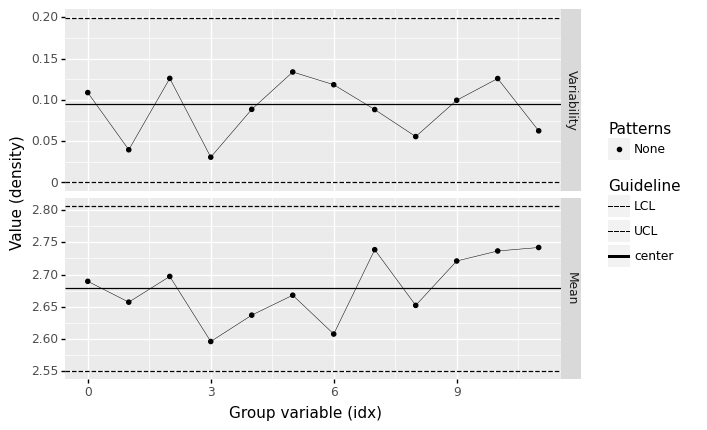

<ggplot: (8767803567897)>

In [19]:
%%capture --no-display
## TODO: Construct batches and make a control chart
(
    df_shewhart
    >> gr.tf_mutate(idx=DF.index // 5)
    >> gr.pt_xbs(group="idx", var="density")
)


*Observations*

- What *assumptions* did you have to make in order to construct rational batches?
  - To group observations into consecutive batches, we need to assume that the data are reported in the order they were collected.
- Based on the batch size you chose, did you find any out-of-control patterns? Did it occur in the `Variability` or batch `Mean`?
  - No; I found no out-of-control patterns.
- If you answered "yes" to the previous question: Based on the batch size you chose, are those patterns likely to be spurious?
  - NA
- Is the `density` likely to be under statistical control?
  - Yes; I find no evidence of out-of-control behavior.
<!-- solution-end -->

### __q5__ Assess the `tensile_strength`

Assess the state of statistical control for the variable `tensile_strength` using a control chart.

Answer the questions under *observations* below.


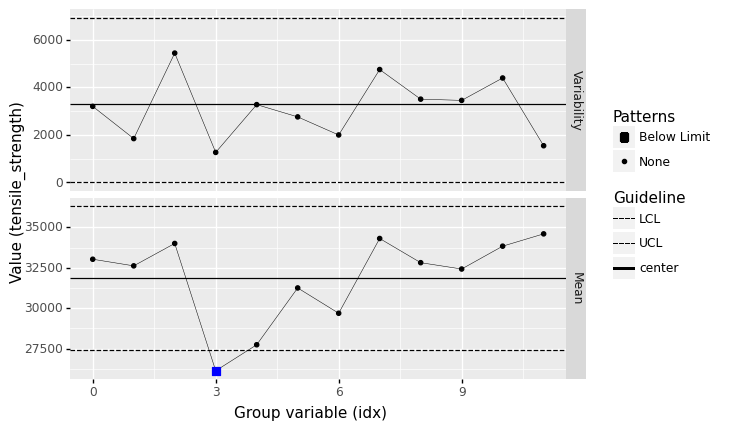

<ggplot: (8767765329321)>

In [20]:
%%capture --no-display
## TODO: Construct batches and make a control chart
(
    df_shewhart
    >> gr.tf_mutate(idx=DF.index // 5)
    >> gr.pt_xbs(group="idx", var="tensile_strength")
)


*Observations*

- What *assumptions* did you have to make in order to construct rational batches?
  - To group observations into consecutive batches, we need to assume that the data are reported in the order they were collected.
- Based on the batch size you chose, did you find any out-of-control patterns? Did it occur in the `Variability` or batch `Mean`?
  - Yes; at a batch size of `n=5` I found the mean to violate the LCL.
- If you answered "yes" to the previous question: Based on the batch size you chose, are those patterns likely to be spurious?
  - Possibly; `n=5` is a very small batch size, so this could certainly be due to chance.
- Is the `tensile_strength` likely to be under statistical control?
  - Possibly; I find that the below LCL batch mean persists for batch sizes of `n=6,7,8,9`, which suggests the process may have been out of control for some of the earlier runs. However, the below LCL case disappears for `n=10`; it is possible that this pattern is spurious.
<!-- solution-end -->

# References

- Kenett and Zacks, *Modern Industrial Statistics*, 2nd Edition (2014)
